## GradCAM Implementation 
https://arxiv.org/pdf/1610.02391.pdf

In [1]:
import numpy as np
import keras 
from skimage.transform import resize
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import matplotlib.pyplot as plt
from IPython.display import Image

Using TensorFlow backend.


In [2]:
# Using VGG16 Model

In [3]:
model = VGG16(weights="imagenet")

In [4]:
print(model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

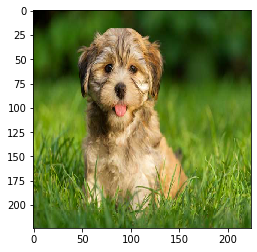

In [5]:
img_1_initial = load_img("cute-puppy-body-image.jpg", target_size=(224, 224))
plt.imshow(img_1_initial)
img_1 = img_to_array(img_1_initial)
img_1 = img_1.reshape((1, img_1.shape[0], img_1.shape[1], img_1.shape[2]))
img_1 = preprocess_input(img_1)


In [6]:
predict = model.predict(img_1)
decode_predictions(predict)

[[('n02094114', 'Norfolk_terrier', 0.39240992),
  ('n02096437', 'Dandie_Dinmont', 0.2504062),
  ('n02097474', 'Tibetan_terrier', 0.09021719),
  ('n02098105', 'soft-coated_wheaten_terrier', 0.04697506),
  ('n02095570', 'Lakeland_terrier', 0.043270625)]]

In [108]:
last_layer = model.get_layer('block5_conv3')
grads = keras.backend.gradients(model.output,last_layer.output)[0]
print(grads)

Tensor("gradients_21/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)


In [109]:
pooled_grads = keras.backend.mean(grads,axis=(0,1,2))
iterate = keras.backend.function([model.input],[pooled_grads,last_layer.output[0]])
pooled_grads_value,conv_layer_output = iterate([img_1])

In [110]:
for i in range(512):
    conv_layer_output[:,:,i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output,axis=-1)


In [111]:
# Applying ReLU to the heatmap 
heatmap = np.maximum(heatmap,0)

In [112]:
# Upscaling
heatmap_resized = resize(heatmap, (224,224), preserve_range=True)

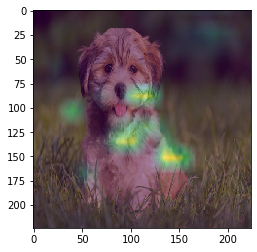

In [113]:
plt.imshow(heatmap_resized)
plt.imshow(img_1_initial, alpha=0.5)

In [94]:
def grad_cam(model, image, cls, layer_name):
    y_c = model.output[0, 0]
    conv_output = model.get_layer(layer_name).output
    grads = keras.backend.gradients(y_c, conv_output)[0]

    gradient_function = keras.backend.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    heatmap = np.dot(output, weights)
    heatmap_resized = resize(heatmap, (224,224), preserve_range=True)
    heatmap_resized = np.maximum(heatmap, 0)
    heatmap_resized = heatmap_resized / np.max(heatmap_resized)
    return heatmap_resized


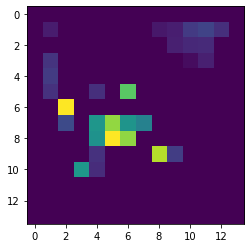

In [95]:
plt.imshow(img_1_initial)
plt.imshow(grad_cam(model, img_1, 2,"block5_conv3" ), alpha=1)


In [91]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [34]:
conv_output = model.get_layer("block5_conv3").output

In [35]:
grads = keras.backend.gradients(y_c, conv_output)[0]

In [37]:
keras.backend.function([model.input], [conv_output, grads])

<tf.Tensor 'Identity_1:0' shape=(None, 14, 14, 512) dtype=float32>